In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, auc, roc_curve
import itertools
import yaml
import os
import numpy as np
from sklearn.metrics import auc
from statistics import mean
from sklearn.metrics import f1_score, make_scorer, precision_score, recall_score
import sys
pd.set_option('display.max_columns', None)


In [2]:
root_dir = os.path.abspath(os.path.join(os.path.dirname('see_all_expewriments.ipynb'), '..'))
os.chdir(root_dir)
sys.path.insert(0, os.path.join(root_dir, 'src'))

In [3]:
def calculate_auc_avg(tickers, predictions, true_values):
    predictions = predictions.sort_values(by='fecha')
    true_values = true_values.sort_values(by='fecha')
    
    
    # renombro las columnas
    column_names = {}
    for column in predictions.columns:
        if column != 'fecha':
            column_names[column] = f'{column}_pred'
    
    predictions = predictions.rename(columns=column_names)
    
    column_names = {}
    for column in true_values.columns:
        if column != 'fecha':
            column_names[column] = f'{column}_true'
    
    true_values = true_values.rename(columns=column_names)
    performance = pd.concat(
        [
            predictions,
            true_values
        ], axis=1, join="inner"
    )
    
    auc_list = []
    for ticker in tickers:
        y_true = performance[performance[f'{ticker}_true'].notna()][f'{ticker}_true']
        y_pred = performance[performance[f'{ticker}_pred'].notna()][f'{ticker}_pred']
        
        precision = precision_score(y_true, y_pred, average='weighted')
        recall = recall_score(y_true, y_pred, average='weighted')
        f1 = f1_score(y_true, y_pred, average='weighted')
        
        auc_list.append(precision)

    return mean(auc_list)

In [4]:
def max_drawdown(serie):
    max_valor_acumulado = serie[0]
    max_dd = 0

    for valor_actual in serie[1:]:
        if valor_actual > max_valor_acumulado:
            max_valor_acumulado = valor_actual
        else:
            dd = (max_valor_acumulado - valor_actual) / max_valor_acumulado
            if dd > max_dd:
                max_dd = dd

    return max_dd

In [5]:
def calculate_avg_returns_perc(orders):
    orders_per_month = orders[['close_time','profit', 'comment']].copy()
    orders_per_month['close_time'] = pd.to_datetime(orders_per_month['close_time'])
    orders_per_month['year'] = orders_per_month['close_time'].dt.year
    orders_per_month['month'] = orders_per_month['close_time'].dt.month
    
    orders_per_month_gb = orders_per_month.groupby(by=['year','month']).agg(
        profit_sum=('profit', 'sum'),
    ).reset_index()
    
    orders_per_month_gb = pd.concat([
        pd.DataFrame({'year':[2023], 'month':[0],'amount_ops':[0], 'profit_sum':[initial_wallet_value]}), 
        orders_per_month_gb
    ])
    
    orders_per_month_gb['profit_cumsum'] = orders_per_month_gb['profit_sum'].cumsum()
    
    orders_per_month_gb['perc_change'] = ((orders_per_month_gb['profit_cumsum'] - orders_per_month_gb['profit_cumsum'].shift(1)) / orders_per_month_gb['profit_cumsum'].shift(1))
    
    return orders_per_month_gb.perc_change.mean(), orders_per_month_gb.perc_change.std()

In [6]:
with open('configs/parameters.yml', 'r') as archivo:
    parameters = yaml.safe_load(archivo)

In [7]:
eta = 0
for param, value in parameters.items():
    if eta == 0:
        eta += len(value)
    else:
        eta *= len(value)

eta = (eta * 10) / 60

print(f'el tiempo estimado de los experimentos es de {round(eta, 2)} horas')

el tiempo estimado de los experimentos es de 0.33 horas


In [8]:
with open('configs/project_config.yml', 'r') as archivo:
    config = yaml.safe_load(archivo)
tickers = config["tickers"] 
tickers

['EURUSD', 'GBPUSD', 'USDJPY', 'USDCAD', 'AUDUSD', 'USDCHF']

In [9]:
results_dict = {}
initial_wallet_value = config['start_money']

for path in os.listdir('./backbone/data/backtest/experiments'):
    if not path.endswith('.csv') and path.startswith('Mode_train'):
        print(path)
        results_dict[path] = {}

        try:
            wallet = pd.read_csv(os.path.join('./backbone/data/backtest/experiments', path, 'wallet.csv'))

            final_wallet_value = wallet.tail(1).iloc[0]['wallet']
            results_dict[path]['wallet'] = ((final_wallet_value - initial_wallet_value) / initial_wallet_value) * 100
            results_dict[path]['max_drawdown'] = max_drawdown(wallet['wallet'])
        except:
            results_dict[path]['wallet'] = 0

        try:
            orders = pd.read_csv(os.path.join('./backbone/data/backtest/experiments', path, 'orders.csv'))

            mean_returns, std_returns = calculate_avg_returns_perc(orders)
            results_dict[path]['mean_perc_returns'] = mean_returns
            results_dict[path]['std_perc_returns'] = std_returns
            
            
            results_dict[path]['buys'] = orders[orders['open_time'].notna()].shape[0]
            results_dict[path]['sells'] = orders[orders['close_time'].notna()].shape[0]
           
            # avg_incomes = orders.groupby('ticker')['profit'].sum().mean()
            # results_dict[path]['avg_incomes'] = avg_incomes
            results_dict[path]['good_operations'] = orders[orders['profit'] >= 0].shape[0]
            results_dict[path]['bad_operations'] = orders[orders['profit'] < 0].shape[0]
    
            results_dict[path]['operation_ratio'] = results_dict[path]['good_operations'] / (results_dict[path]['good_operations'] + results_dict[path]['bad_operations']) 


            # Tasa de rendimiento libre de riesgo anual
            annual_risk_free_rate = 0.02
            hours_per_year = 252 * 24
            hourly_risk_free_rate = (1 + annual_risk_free_rate) ** (1/hours_per_year) - 1
            mean_hourly_return = orders['profit'].mean()
            std_hourly_return = orders['profit'].std()
            sharpe_ratio_hourly = (mean_hourly_return - hourly_risk_free_rate) / std_hourly_return
            sharpe_ratio_annualized = sharpe_ratio_hourly * np.sqrt(hours_per_year)

            results_dict[path]['sharpe_ratio'] = sharpe_ratio_annualized
        
            results_dict[path]['winning_rate'] = orders[orders['profit'] >= 0]['profit'].mean() / (-1 * orders[orders['profit'] < 0]['profit'].mean())
            
            results_dict[path]['recover_factor'] = orders[orders['profit'] >= 0]['profit'].sum() / (-1 * orders[orders['profit'] < 0]['profit'].sum())

            results_dict[path]['stability_index'] = orders['profit'].std() / orders['profit'].mean()

            for ticker in tickers:
                results_dict[path][f'profits_in_{ticker}'] = orders[orders['ticker'] == ticker]['profit'].sum()

        except:
            results_dict[path]['buys'] = 0
            results_dict[path]['sells'] = 0
            avg_incomes = 0
            results_dict[path]['avg_incomes'] = 0
            results_dict[path]['good_operations'] = 0
            results_dict[path]['bad_operations'] = 0
            results_dict[path]['operation_ratio'] = 0
        # try:
        train_results = pd.read_csv(os.path.join('./backbone/data/backtest/experiments', path, 'trainres.csv')).dropna()
        results_dict[path]['avg_train_precision'] = train_results['precision'].mean()
        results_dict[path]['avg_train_recall'] = train_results['recall'].mean()
        results_dict[path]['avg_train_f1'] = train_results['f1'].mean()
        # # except:
        # #     results_dict[path]['avg_train_auc'] = 0
            
        # # try:
        predictions = pd.read_csv(os.path.join('./backbone/data/backtest/experiments', path, 'test_res.csv')).dropna()

        results_dict[path]['avg_test_precision'] = precision_score(predictions.y_true, predictions.y_pred, average='weighted')
        results_dict[path]['avg_test_recall'] = recall_score(predictions.y_true, predictions.y_pred, average='weighted')
        results_dict[path]['avg_test_f1'] = f1_score(predictions.y_true, predictions.y_pred, average='weighted')
        # except:
        #     results_dict[path]['avg_test_auc'] = 0

results = pd.DataFrame.from_dict(results_dict, orient='index')

Mode_train-Model_gradient_boosting-TrainWw_11520-TrainPd_24-TradStgy_ml_strategy-PerFwTg_8-SL_15-RR_2-CloseByTimeTrue-TS_False
Mode_train-Model_random_forest-TrainWw_11520-TrainPd_24-TradStgy_ml_strategy-PerFwTg_8-SL_15-RR_2-CloseByTimeTrue-TS_False


In [10]:
beta = 0.05
eurusd = pd.read_csv('./backbone/data/backtest/symbols/EURUSD.csv')
results['buy_ratio'] = results['buys'] / (eurusd.Date.nunique() * len(tickers))
results['operation_ratio_2'] = ((1 + beta**2) * results['operation_ratio'] * results['buy_ratio']) / (beta * results['operation_ratio'] + results['buy_ratio'])

In [11]:
positive_results = results[
    [
        'operation_ratio_2',
        'operation_ratio', 
        'buy_ratio',
        'mean_perc_returns',
        'std_perc_returns',
        'winning_rate',
        'recover_factor',
        'sharpe_ratio',
        'stability_index',
        'max_drawdown',
        'good_operations',
        'bad_operations',
        'wallet',
        # 'profits_in_EURUSD',
        # 'profits_in_GBPUSD', 
        # # 'profits_in_USDJPY', 
        # 'profits_in_USDCAD',
        # 'profits_in_AUDUSD', 
        # 'profits_in_USDCHF',
        'avg_train_precision',
        'avg_train_recall',
        'avg_train_f1',
        'avg_test_precision',
        'avg_test_recall',
        'avg_test_f1',
    ]
]#.sort_values(by='sharpe_ratio', ascending=False)

# positive_results = positive_results[
#     (results['wallet']>5000)
#     & (results['max_drawdown']<=0.1)
# ].sort_values(by='sharpe_ratio', ascending=False)


positive_results

,operation_ratio_2,operation_ratio,buy_ratio,mean_perc_returns,std_perc_returns,winning_rate,recover_factor,sharpe_ratio,stability_index,max_drawdown,good_operations,bad_operations,wallet,avg_train_precision,avg_train_recall,avg_train_f1,avg_test_precision,avg_test_recall,avg_test_f1
Mode_train-Model_gradient_boosting-TrainWw_11520-TrainPd_24-TradStgy_ml_strategy-PerFwTg_8-SL_15-RR_2-CloseByTimeTrue-TS_False,0.059937,0.695853,0.003270,0.365654,0.090363,1.929372,4.414169,44.752402,1.737759,0.034929,151,66,541.36190,0.755829,0.654085,0.667980,0.611320,0.540187,0.545579
Mode_train-Model_random_forest-TrainWw_11520-TrainPd_24-TradStgy_ml_strategy-PerFwTg_8-SL_15-RR_2-CloseByTimeTrue-TS_False,0.048676,0.705202,0.002607,0.291565,0.064870,1.724696,4.125743,44.275660,1.756470,0.040035,122,51,361.18345,0.750308,0.608514,0.620108,0.607414,0.504673,0.499403


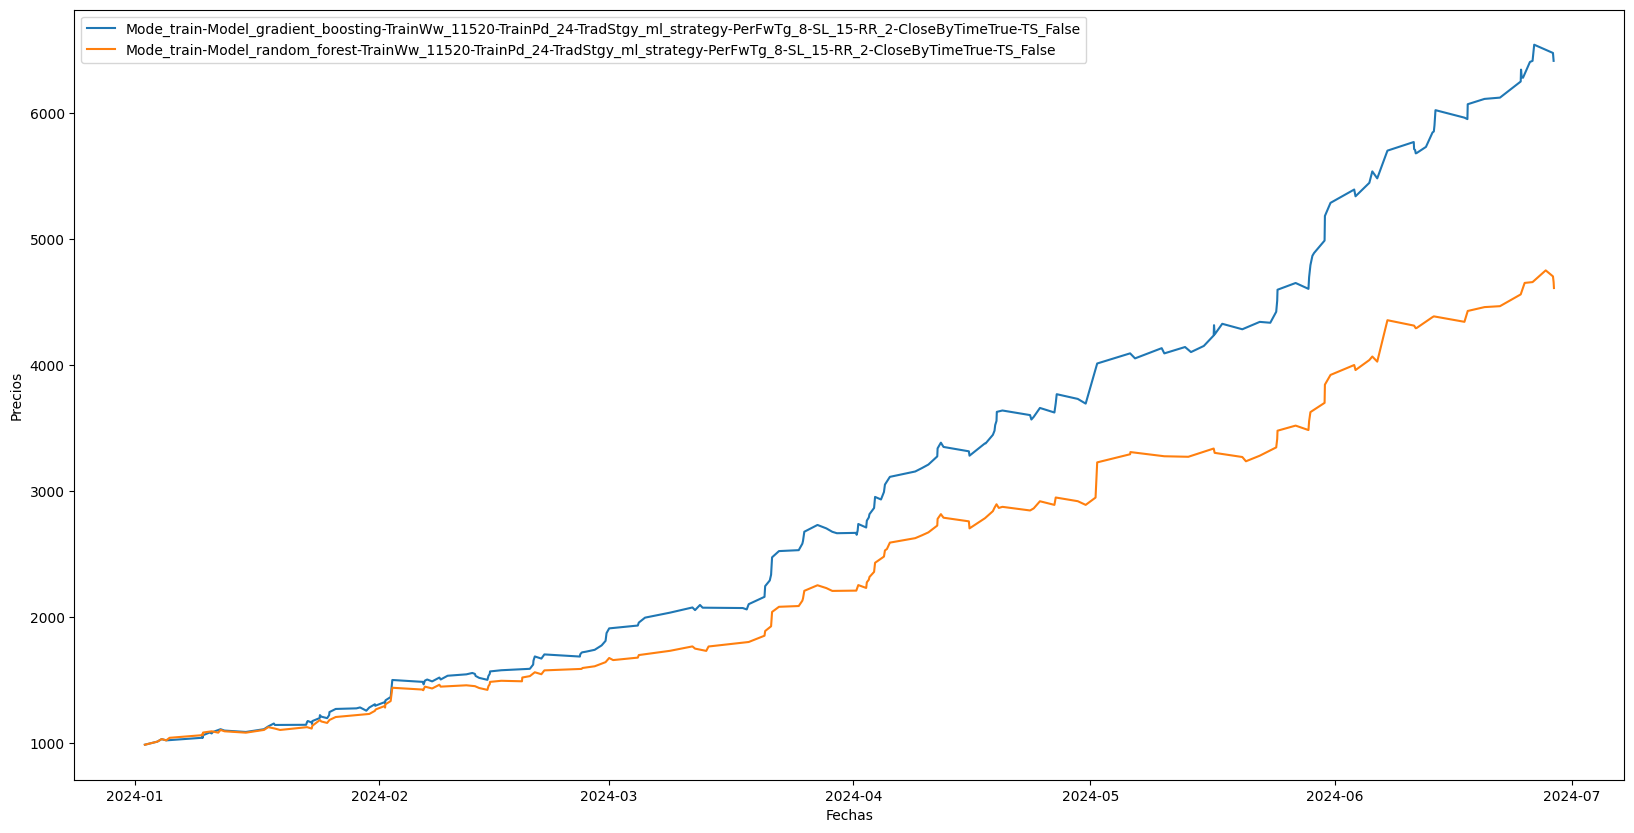

In [12]:
import time
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output

filter_results = positive_results
fig, ax = plt.subplots(figsize=(20, 10))
for path in filter_results.index:

    wallet = pd.read_csv(os.path.join('./backbone/data/backtest/experiments', path, 'wallet.csv'))

    # Datos de ejemplo
    x_wallet = pd.to_datetime(wallet['date'])
    y_wallet = wallet['wallet']  # Datos para la línea
    
    # Crear una figura y ejes
    
    # Agregar la línea
    ax.plot(x_wallet, y_wallet, label=f'{path}')
    
# Etiquetas de los ejes y leyenda
ax.set_xlabel('Fechas')
ax.set_ylabel('Precios')
ax.legend()
    
    # Mostrar el gráfico
    # print(path)
plt.show()
    # time.sleep(5)
    # clear_output(wait=True)

In [13]:
import re

In [14]:
filter_results = results[results['wallet']>0]


In [15]:
filter_results = filter_results.reset_index().rename(columns={'index':'experiment'})

In [16]:
filter_results['model'] = filter_results['experiment'].apply(lambda x: re.search(r'-Model_(.*?)-', x).group(1))
filter_results['window'] = filter_results['experiment'].apply(lambda x: re.search(r'-TrainWw_(.*?)-', x).group(1))
filter_results['train_period'] = filter_results['experiment'].apply(lambda x: re.search(r'-TrainPd_(.*?)-', x).group(1))
filter_results['strategy'] = filter_results['experiment'].apply(lambda x: re.search(r'-TradStgy_(.*?)-', x).group(1))
filter_results['periods_forward_target'] = filter_results['experiment'].apply(lambda x: re.search(r'-PerFwTg_(.*?)-', x).group(1))
filter_results['sl'] = filter_results['experiment'].apply(lambda x: re.search(r'-SL_(.*?)-', x).group(1))
filter_results['rr'] = filter_results['experiment'].apply(lambda x: re.search(r'-RR_(.*?)-', x).group(1))
# filter_results['use_days_to_close'] = filter_results['experiment'].apply(lambda x: x.split('UseDaysClose_')[1])

In [17]:
print(filter_results['strategy'].value_counts())
print('-----------------------------------------')
print(filter_results['model'].value_counts())
print('-----------------------------------------')
print(filter_results['window'].value_counts())
print('-----------------------------------------')
print(filter_results['rr'].value_counts())
print('-----------------------------------------')
print(filter_results['sl'].value_counts())
print('-----------------------------------------')
print(filter_results['periods_forward_target'].value_counts())

strategy
ml_strategy    2
Name: count, dtype: int64
-----------------------------------------
model
gradient_boosting    1
random_forest        1
Name: count, dtype: int64
-----------------------------------------
window
11520    2
Name: count, dtype: int64
-----------------------------------------
rr
2    2
Name: count, dtype: int64
-----------------------------------------
sl
15    2
Name: count, dtype: int64
-----------------------------------------
periods_forward_target
8    2
Name: count, dtype: int64


In [18]:
gb = filter_results.groupby(
    by=['strategy', 'model', 'window', 'rr', 'periods_forward_target']
).agg(
    {
        'sharpe_ratio':['mean', 'std']
    }
)


gb.sort_values(by=('sharpe_ratio', 'mean'), ascending=False).dropna().round(4)

Empty DataFrame
Columns: [(sharpe_ratio, mean), (sharpe_ratio, std)]
Index: []

In [19]:
filter_results[filter_results['rr']=='2'].sort_values(by='sharpe_ratio', ascending=False)

,experiment,wallet,max_drawdown,mean_perc_returns,std_perc_returns,buys,sells,good_operations,bad_operations,operation_ratio,sharpe_ratio,winning_rate,recover_factor,stability_index,profits_in_EURUSD,profits_in_GBPUSD,profits_in_USDJPY,profits_in_USDCAD,profits_in_AUDUSD,profits_in_USDCHF,avg_train_precision,avg_train_recall,avg_train_f1,avg_test_precision,avg_test_recall,avg_test_f1,buy_ratio,operation_ratio_2,model,window,train_period,strategy,periods_forward_target,sl,rr
0,Mode_train-Model_gradient_boosting-TrainWw_115...,541.36190,0.034929,0.365654,0.090363,217,217,151,66,0.695853,44.752402,1.929372,4.414169,1.737759,799.5144,772.8238,1388.913,1086.0760,643.9834,722.3084,0.755829,0.654085,0.667980,0.611320,0.540187,0.545579,0.003270,0.059937,gradient_boosting,11520,24,ml_strategy,8,15,2
1,Mode_train-Model_random_forest-TrainWw_11520-T...,361.18345,0.040035,0.291565,0.064870,173,173,122,51,0.705202,44.275660,1.724696,4.125743,1.756470,562.8989,694.2867,1064.844,917.5396,183.1524,189.1129,0.750308,0.608514,0.620108,0.607414,0.504673,0.499403,0.002607,0.048676,random_forest,11520,24,ml_strategy,8,15,2


In [20]:
gb = filter_results.groupby(
    by=['rr']
).agg(
    {
        'sharpe_ratio':['mean', 'std']
    }
)


gb.sort_values(by=('sharpe_ratio','mean'), ascending=False)

sharpe_ratio          
           mean       std
rr                       
2     44.514031  0.337107

In [21]:
gb = filter_results.groupby(
    by=['sl']
).agg(
    {
        'sharpe_ratio':['mean', 'std']
    }
)


gb.sort_values(by=('sharpe_ratio','mean'), ascending=False)

sharpe_ratio          
           mean       std
sl                       
15    44.514031  0.337107

In [22]:
gb = filter_results.groupby(
    by=['window']
).agg(
    {
        'sharpe_ratio':['mean', 'std']
    }
)


gb.sort_values(by=('sharpe_ratio','mean'), ascending=False)

sharpe_ratio          
               mean       std
window                       
11520     44.514031  0.337107

In [23]:
gb = filter_results.groupby(
    by=['periods_forward_target']
).agg(
    {
        'sharpe_ratio':['mean', 'std']
    }
)


gb.sort_values(by=('sharpe_ratio','mean'), ascending=False)

sharpe_ratio          
                               mean       std
periods_forward_target                       
8                         44.514031  0.337107

In [24]:
gb = filter_results.groupby(
    by=['model']
).agg(
    {
        'sharpe_ratio':['mean', 'std']
    }
)


gb.sort_values(by=('sharpe_ratio','mean'), ascending=False)

sharpe_ratio    
                          mean std
model                             
gradient_boosting    44.752402 NaN
random_forest        44.275660 NaN

In [25]:
0/0

ZeroDivisionError: division by zero

In [ ]:
results_dict = {}

for path in os.listdir('./data'):
    if not path.endswith('.csv') and path.startswith('test_'):
        print(path)
        results_dict[path] = {}

        try:
            wallet = pd.read_csv(os.path.join('./data', path, 'wallet.csv'))
            results_dict[path]['wallet'] = wallet.tail(1).iloc[0]['wallet']
        except:
            results_dict[path]['wallet'] = 0

        try:
            orders = pd.read_csv(os.path.join('./data', path, 'orders.csv'))
            results_dict[path]['buys'] = orders[orders['open_date'].notna()].shape[0]
            results_dict[path]['sells'] = orders[orders['close_date'].notna()].shape[0]
           
            avg_incomes = orders.groupby('ticker')['profit'].sum().mean()
            results_dict[path]['avg_incomes'] = avg_incomes
            results_dict[path]['good_operations'] = orders[orders['profit'] > 0].shape[0]
            results_dict[path]['bad_operations'] = orders[orders['profit'] <= 0].shape[0]
            results_dict[path]['operation_ratio'] = results_dict[path]['good_operations'] / (results_dict[path]['good_operations'] + results_dict[path]['bad_operations']) 

        except:
            results_dict[path]['buys'] = 0
            results_dict[path]['sells'] = 0
            avg_incomes = 0
            results_dict[path]['avg_incomes'] = 0
            results_dict[path]['good_operations'] = 0
            results_dict[path]['bad_operations'] = 0
            results_dict[path]['operation_ratio'] = 0

        try:
            train_results = pd.read_csv(os.path.join('./data', path, 'train_results.csv'))
            avg_train_auc = train_results['auc'].mean()
            results_dict[path]['avg_train_auc'] = avg_train_auc
        except:
            results_dict[path]['avg_train_auc'] = 0
            
        try:
            stock_predictions = pd.read_csv(os.path.join('./data', path, 'stock_predictions.csv'))
            true_values = pd.read_csv(os.path.join('./data', path, 'stock_true_values.csv'))

            avg_auc_score = calculate_auc_avg(tickers, stock_predictions, true_values)
            results_dict[path]['avg_test_auc'] = avg_auc_score
        except:
            results_dict[path]['avg_test_auc'] = 0

results = pd.DataFrame.from_dict(results_dict, orient='index')


Mode_train-Model_random_forest-TrainWw_720-TrainPd_24-TradingStgy_macd_strategy-PeriodsFwTg_8-SL_15-RR_3-UseDaysClose_False

Mode_train-Model_random_forest-TrainWw_1440-TrainPd_24-TradingStgy_macd_strategy-PeriodsFwTg_8-SL_15-RR_3-UseDaysClose_False

Mode_train-Model_random_forest-TrainWw_1440-TrainPd_24-TradingStgy_macd_strategy-PeriodsFwTg_8-SL_15-RR_2-UseDaysClose_False

Mode_train-Model_random_forest-TrainWw_720-TrainPd_24-TradingStgy_macd_strategy-PeriodsFwTg_8-SL_15-RR_2-UseDaysClose_False

Mode_train-Model_random_forest-TrainWw_960-TrainPd_24-TradingStgy_macd_strategy-PeriodsFwTg_5-SL_15-RR_3-UseDaysClose_False







Mode_train-Model_gradient_boosting-TrainWw_1440-TrainPd_24-TradingStgy_macd_strategy-PeriodsFwTg_8-SL_15-RR_3-UseDaysClose_False

Mode_train-Model_random_forest-TrainWw_960-TrainPd_24-TradingStgy_macd_strategy-PeriodsFwTg_8-SL_15-RR_3-UseDaysClose_False